In [1]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Load training and Validation arrays

In [2]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [3]:
npzfile = np.load('half_shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(12788, 320, 128) (12788,)


In [4]:
npzfile = np.load('half_shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(1600, 320, 128) (1600,)


### Check by plotting a Spectogram

Electronic


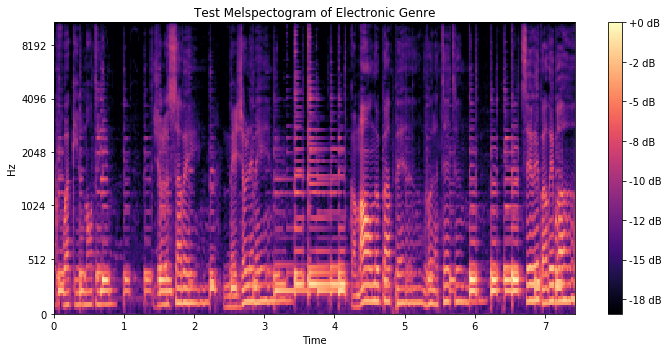

In [5]:
num = 5300
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram'+' of '+reverse_map[genre]+' Genre')
plt.tight_layout()

### Parallel CNN - RNN Model

In [6]:
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [7]:
nb_filters1=16 
nb_filters2=32 
nb_filters3=64
nb_filters4=64
nb_filters5=64
ksize = (3,1)
pool_size_1= (2,2) 
pool_size_2= (4,4)
pool_size_3 = (4,2)

dropout_prob = 0.20
dense_size1 = 128
lstm_count = 64
num_units = 120

BATCH_SIZE = 64
EPOCH_COUNT = 50
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_2)(conv_4)
    
    
    conv_5 = Conv2D(filters = nb_filters5, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_5')(pool_4)
    pool_5 = MaxPooling2D(pool_size_2)(conv_5)

    flatten1 = Flatten()(pool_5)
    ### Recurrent Block
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_3, name = 'pool_lstm')(layer)
    
    # Embedding layer

    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
#     flatten2 = K.squeeze(pool_lstm1, axis = -1)
#     dense1 = Dense(dense_size1)(flatten)
    
    # Bidirectional GRU
    lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat
    
    # Concat Output
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat')
    
    ## Softmax Output
    output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
    
    model_output = output
    model = Model(model_input, model_output)
    
#     opt = Adam(lr=0.001)
    opt = RMSprop(lr=0.0005)  # Optimizer
    model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [8]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_frequency = 128
    n_frames = 320
    #reshape and expand dims for conv2d
#     x_train = x_train.reshape(-1, n_frequency, n_frames)
    x_train = np.expand_dims(x_train, axis = -1)
#     y_train = np.expand_dims(y_train, axis = -1)
    
#     x_val = x_val.reshape(-1, n_frequency, n_frames)
    x_val = np.expand_dims(x_val, axis = -1)
#     y_val = np.expand_dims(y_val, axis = -1)
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/parallel/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train,epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val),
                        verbose=1,
                        callbacks=callbacks_list
                       )

    return model, history


In [9]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [10]:
print(X_train.shape,y_train.shape)
print(X_valid.shape,y_valid.shape)

(12788, 320, 128) (12788,)
(1600, 320, 128) (1600,)


In [11]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)


Building model...





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 320, 128, 1)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 318, 128, 16) 64          input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 159, 64, 16)  0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 157, 64, 32)  1568        max_pooling2d_1[0][0]            
_____________________________________________________________________________________

12788/12788 [==============================] - 143s 11ms/step - loss: 1.4636 - acc: 0.4829 - val_loss: 1.6215 - val_acc: 0.4219

Epoch 00006: val_acc did not improve from 0.42562
Epoch 7/50
12788/12788 [==============================] - 146s 11ms/step - loss: 1.4428 - acc: 0.4902 - val_loss: 1.5224 - val_acc: 0.4288

Epoch 00007: val_acc improved from 0.42562 to 0.42875, saving model to ./models/parallel/weights.best.h5
Epoch 8/50
12788/12788 [==============================] - 147s 12ms/step - loss: 1.4099 - acc: 0.5054 - val_loss: 1.5198 - val_acc: 0.4150

Epoch 00008: val_acc did not improve from 0.42875
Epoch 9/50
12788/12788 [==============================] - 153s 12ms/step - loss: 1.3870 - acc: 0.5131 - val_loss: 1.5778 - val_acc: 0.4313

Epoch 00009: val_acc improved from 0.42875 to 0.43125, saving model to ./models/parallel/weights.best.h5
Epoch 10/50
12788/12788 [==============================] - 157s 12ms/step - loss: 1.3702 - acc: 0.5184 - val_loss: 1.5677 - val_acc: 0.4544



12788/12788 [==============================] - 271s 21ms/step - loss: 0.7726 - acc: 0.7452 - val_loss: 1.6433 - val_acc: 0.4813

Epoch 00046: val_acc did not improve from 0.51938
Epoch 47/50
12788/12788 [==============================] - 282s 22ms/step - loss: 0.7677 - acc: 0.7462 - val_loss: 1.6160 - val_acc: 0.4819

Epoch 00047: val_acc did not improve from 0.51938
Epoch 48/50
12788/12788 [==============================] - 278s 22ms/step - loss: 0.7630 - acc: 0.7527 - val_loss: 1.6595 - val_acc: 0.4706

Epoch 00048: val_acc did not improve from 0.51938
Epoch 49/50
12788/12788 [==============================] - 283s 22ms/step - loss: 0.7601 - acc: 0.7503 - val_loss: 1.6098 - val_acc: 0.4800

Epoch 00049: val_acc did not improve from 0.51938
Epoch 50/50
12788/12788 [==============================] - 286s 22ms/step - loss: 0.7559 - acc: 0.7525 - val_loss: 1.6304 - val_acc: 0.4838

Epoch 00050: val_acc did not improve from 0.51938


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


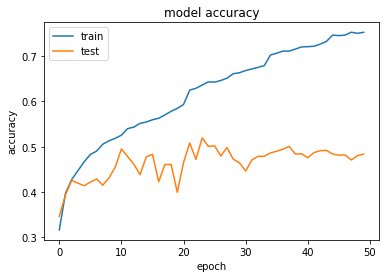

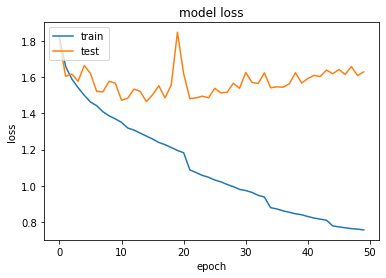

In [12]:
show_summary_stats(history)

In [14]:
from sklearn.metrics import classification_report

y_true = y_valid
print(y_true)
X_test_val = np.expand_dims(X_valid, axis = -1)
y_pred_1 = model.predict(X_test_val)
print("y_pred_1")
print(y_pred_1)
y_pred_2 = np.argmax(y_pred_1, axis=1)

print("y_pred_2")
print(y_pred_2)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred_2.shape)
print(classification_report(y_true, y_pred_2, target_names=target_names))


[2 7 2 ... 2 6 1]
y_pred_1
[[2.9458614e-02 9.2657760e-02 2.2488871e-01 ... 6.1357591e-02
  4.3951672e-01 8.2666211e-02]
 [1.8876456e-04 1.8269866e-03 2.7341435e-02 ... 3.8632378e-02
  8.9247569e-02 8.3940673e-01]
 [3.8534345e-05 1.3896857e-02 2.7964178e-02 ... 3.8332000e-02
  8.9238101e-01 2.2382528e-02]
 ...
 [5.4790201e-03 1.9174343e-02 7.1428347e-01 ... 7.0679188e-02
  1.3682291e-01 2.8083388e-02]
 [2.3637705e-02 3.3964336e-02 1.3511354e-02 ... 1.1312712e-03
  2.1333175e-02 1.1605569e-03]
 [2.1395399e-01 4.2620325e-01 1.1801735e-02 ... 2.7359892e-02
  1.4405211e-02 1.6352285e-02]]
y_pred_2
[6 7 6 ... 2 4 1]
(1600,) (1600,)
               precision    recall  f1-score   support

   Electronic       0.42      0.54      0.47       200
 Experimental       0.42      0.43      0.43       200
         Folk       0.63      0.62      0.63       200
      Hip-Hop       0.70      0.48      0.57       200
 Instrumental       0.46      0.45      0.45       200
International       0.56      0.60 

In [121]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred_2))

0.14625


In [136]:
npzfile = np.load('half_test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
y_test = y_test -1
z_header = npzfile['arr_2']
print(X_test.shape, y_test.shape,z_header.shape)

['arr_0', 'arr_1', 'arr_2']
(1600, 320, 128) (1600,) (2, 1600)


In [137]:
from keras.models import load_model

weights_path = 'models/parallel/weights.best.h5'
model = load_model(weights_path)

In [138]:
# y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 7 3.5


In [139]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0 0.005247334162755299


In [140]:
X_test_raw = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
X_test_raw = np.expand_dims(X_test_raw, axis = -1)
y_pred = model.predict(X_test_raw)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(1600,) (1600,)
               precision    recall  f1-score   support

   Electronic       0.61      0.57      0.59       200
 Experimental       0.25      0.34      0.29       200
         Folk       0.22      0.30      0.25       200
      Hip-Hop       0.62      0.77      0.69       200
 Instrumental       0.49      0.33      0.39       200
International       0.53      0.37      0.44       200
          Pop       0.34      0.12      0.18       200
         Rock       0.48      0.64      0.55       200

     accuracy                           0.43      1600
    macro avg       0.44      0.43      0.42      1600
 weighted avg       0.44      0.43      0.42      1600



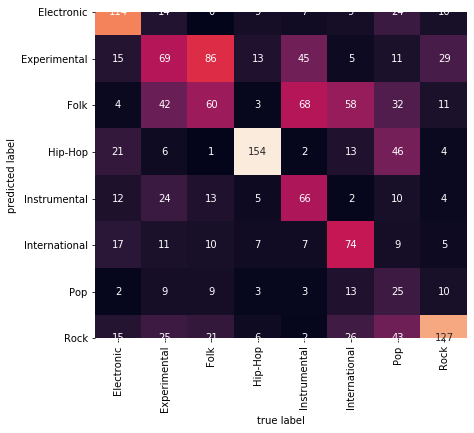

In [141]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

f, ax = plt.subplots(figsize=(9, 6))

mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,ax =ax,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())



plt.xlabel('true label')
plt.ylabel('predicted label');

In [142]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

0.430625


In [143]:
# print("Image data",X_test.shape)
# print("Music Genere", y_test.shape)
# print("Title and Artist",z_header.shape,"\n")

song = 0

print("Genre: ",reverse_map[y_test[song]])
print("Artist: ",z_header[0][song])
print("Song: ",z_header[1][song])
# for row in z_header:
#     print("Artist:",row[song])


# for col in y_test:
#     print(reverse_map[col])    

Genre:  Rock
Artist:  Ariel Pink's Haunted Graffiti
Song:  Jules Lost His Jewels


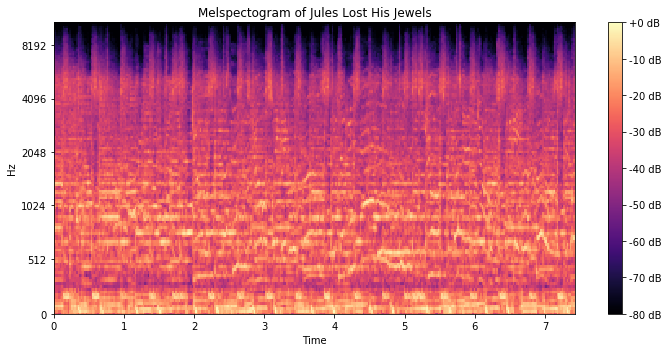

In [144]:
spectogram_test = X_test[song]
genre_test = y_test[song]
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram_test.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Melspectogram'+' of '+ z_header[1][song])
plt.tight_layout()

In [146]:
# y_true = y_test
# X_test_exp = np.expand_dims(X_test, axis = -1)
y_pred_song = model.predict(X_test_raw)

y_pred_song_one = y_pred_song[song]
print(y_pred_song_one)

# y_pred = np.argmax(y_pred, axis=1)
# labels = [0,1,2,3,4,5,6,7]
# target_names = dict_genres.keys()

# print(y_true.shape, y_pred.shape)
# print(classification_report(y_true, y_pred, target_names=target_names))

[0.01814496 0.11405881 0.00891078 0.05233245 0.1209174  0.01861098
 0.17512709 0.49189746]


In [150]:
prediction_song = y_pred_song_one[[3],[4],[7]]
print(prediction_song)

IndexError: too many indices for array